In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
import pickle
import datetime
import time

import matplotlib.pyplot as plt

In [2]:
def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### 1. PCA data

#### Hold-out validation for logisitc regression

In [3]:
X_train, y_train = np.load("data/Z_train.npy"), np.load("data/y_train.npy")
X_val, y_val = np.load("data/Z_val.npy"), np.load("data/y_val.npy")

lam_range = np.logspace(-4,2, 30)

n = X_train.shape[0]
C_range = 1/lam_range * (1/(4*n))

out = {}
for C in C_range:
    tic = time.time()
    model = LogisticRegression(C=C, max_iter=1500).fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_val)
    
    res = {}
    res['model'] = model
    res['valid'] = { "macro_f1": f1_score(y_val, y_pred, average="macro"),
    "accuracy": accuracy_score(y_val, y_pred)}
    res['train'] = { "macro_f1": f1_score(y_train, y_pred_train, average="macro"),
    "accuracy": accuracy_score(y_train, y_pred_train)}
    toc = time.time()
    print('C = {:.5f}, Time: {}'.format(C, format_time(toc-tic)))
    print('Train: {:.4f} || Valid: {:.4f}'.format(res['train']['accuracy'],
                                                 res['valid']['accuracy']))
    print('-'*50)
    out[C] = res

C = 0.10467, Time: 0:01:36
Train: 0.9993 || Valid: 0.9265
--------------------------------------------------
C = 0.06500, Time: 0:01:16
Train: 0.9992 || Valid: 0.9267
--------------------------------------------------
C = 0.04037, Time: 0:00:59
Train: 0.9987 || Valid: 0.9267
--------------------------------------------------
C = 0.02507, Time: 0:01:06
Train: 0.9981 || Valid: 0.9268
--------------------------------------------------
C = 0.01557, Time: 0:00:47
Train: 0.9967 || Valid: 0.9270
--------------------------------------------------
C = 0.00967, Time: 0:00:46
Train: 0.9945 || Valid: 0.9277
--------------------------------------------------
C = 0.00600, Time: 0:00:46
Train: 0.9903 || Valid: 0.9285
--------------------------------------------------
C = 0.00373, Time: 0:00:40
Train: 0.9844 || Valid: 0.9292
--------------------------------------------------
C = 0.00232, Time: 0:00:30
Train: 0.9769 || Valid: 0.9295
--------------------------------------------------
C = 0.00144, Time: 

In [4]:
# save results
logistic_outfile = './out/logistic_valid.pkl'
with open(logistic_outfile, 'wb') as f:
    pickle.dump(out, f)

In [5]:
# plot results
val_acc = [out[c]['valid']['accuracy'] for c in C_range]
train_acc = [out[c]['train']['accuracy'] for c in C_range]

val_f1 = [out[c]['valid']['macro_f1'] for c in C_range]
train_f1 = [out[c]['train']['macro_f1'] for c in C_range]

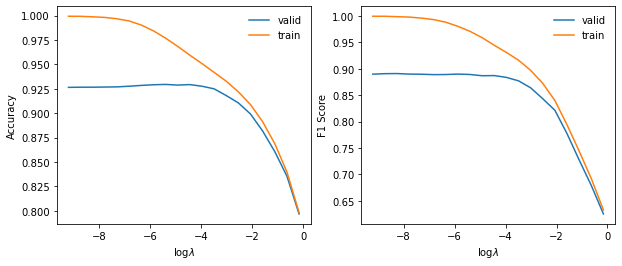

In [8]:
plt.subplots(1,2,figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(np.log(lam_range[:20]), val_acc[:20], label='valid')
plt.plot(np.log(lam_range[:20]), train_acc[:20], label='train')
plt.xlabel(r'$\log \lambda$')
plt.ylabel('Accuracy')
plt.legend(frameon=False)

plt.subplot(1,2,2)
plt.plot(np.log(lam_range[:20]), val_f1[:20], label='valid')
plt.plot(np.log(lam_range[:20]), train_f1[:20], label='train')
plt.xlabel(r'$\log \lambda$')
plt.ylabel('F1 Score')
plt.legend(frameon=False);

#### Hold-out validation for k-nearest-neighbors

In [24]:
X_train, y_train = np.load("data/Z_train.npy"), np.load("data/y_train.npy")
X_val, y_val = np.load("data/Z_val.npy"), np.load("data/y_val.npy")

k_range = np.arange(15)+1

knn_out = {}
for k in k_range:
    tic = time.time()
    model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_val)
    
    res = {}
    res['model'] = model
    res['valid'] = { "macro_f1": f1_score(y_val, y_pred, average="macro"),
    "accuracy": accuracy_score(y_val, y_pred)}
    res['train'] = { "macro_f1": f1_score(y_train, y_pred_train, average="macro"),
    "accuracy": accuracy_score(y_train, y_pred_train)}
    toc = time.time()
    print('k = {}, Time: {}'.format(k, format_time(toc-tic)))
    print('Train: {:.4f} || Valid: {:.4f}'.format(res['train']['accuracy'],
                                                 res['valid']['accuracy']))
    print('-'*50)
    knn_out[k] = res

k = 11, Time: 0:10:55
Train: 0.9054 || Valid: 0.8883
--------------------------------------------------
k = 12, Time: 0:11:01
Train: 0.9030 || Valid: 0.8883
--------------------------------------------------
k = 13, Time: 0:10:57
Train: 0.9012 || Valid: 0.8881
--------------------------------------------------
k = 14, Time: 0:10:57
Train: 0.8993 || Valid: 0.8861
--------------------------------------------------
k = 15, Time: 0:10:58
Train: 0.8987 || Valid: 0.8843
--------------------------------------------------


In [26]:
# save results
knn_outfile = './out/knn_valid.pkl'
with open(knn_outfile, 'wb') as f:
    pickle.dump(knn_out, f)

### 2. Random projection data

In [9]:
# compute and save random projections
X_full = np.load("data/X_train.npy")

n = X_full.shape[0]
d_max = X_full.shape[1]

scaler = StandardScaler().fit(X_full)

# Subset
np.random.seed(123)
idx = np.random.permutation(X_full.shape[0])
X = X_full[idx[0:n], :]

n_orig = np.load("data/X_train.npy").shape[1]
n_proj = np.load("data/Z_train.npy").shape[1]

proj_mat = np.random.normal(size=(n_orig, n_proj))

Z_train = np.dot(scaler.transform(X_full), proj_mat)
Z_val = np.dot(scaler.transform(np.load("data/X_val.npy")), proj_mat)
Z_test = np.dot(scaler.transform(np.load("data/X_test.npy")), proj_mat)

with open("data/Z_train_rand.npy", "wb") as f:
    np.save(f, Z_train)
with open("data/Z_val_rand.npy", "wb") as f:
    np.save(f, Z_val)
with open("data/Z_test_rand.npy", "wb") as f:
    np.save(f, Z_test)

#### Logistic regression

In [12]:
X_train, y_train = np.load("data/Z_train_rand.npy"), np.load("data/y_train.npy")
X_val, y_val = np.load("data/Z_val_rand.npy"), np.load("data/y_val.npy")

lam_range = np.logspace(-4,2, 30)

n = X_train.shape[0]
C_range = 1/lam_range * (1/(4*n))

out = {}
for C in C_range:
    tic = time.time()
    model = LogisticRegression(C=C, max_iter=2500).fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_val)
    
    res = {}
    res['model'] = model
    res['valid'] = { "macro_f1": f1_score(y_val, y_pred, average="macro"),
    "accuracy": accuracy_score(y_val, y_pred)}
    res['train'] = { "macro_f1": f1_score(y_train, y_pred_train, average="macro"),
    "accuracy": accuracy_score(y_train, y_pred_train)}
    toc = time.time()
    print('C = {:.5f}, Time: {}'.format(C, format_time(toc-tic)))
    print('Train: {:.4f} || Valid: {:.4f}'.format(res['train']['accuracy'],
                                                 res['valid']['accuracy']))
    print('-'*50)
    out[C] = res

C = 0.10467, Time: 0:02:19
Train: 0.9993 || Valid: 0.9064
--------------------------------------------------
C = 0.06500, Time: 0:01:57
Train: 0.9993 || Valid: 0.9069
--------------------------------------------------
C = 0.04037, Time: 0:02:03
Train: 0.9993 || Valid: 0.9074
--------------------------------------------------


/home/alec/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C = 0.02507, Time: 0:04:00
Train: 0.9993 || Valid: 0.9094
--------------------------------------------------
C = 0.01557, Time: 0:02:54
Train: 0.9993 || Valid: 0.9096
--------------------------------------------------


/home/alec/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C = 0.00967, Time: 0:04:00
Train: 0.9993 || Valid: 0.9094
--------------------------------------------------
C = 0.00600, Time: 0:02:04
Train: 0.9993 || Valid: 0.9102
--------------------------------------------------


/home/alec/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C = 0.00373, Time: 0:03:59
Train: 0.9993 || Valid: 0.9096
--------------------------------------------------
C = 0.00232, Time: 0:02:13
Train: 0.9993 || Valid: 0.9108
--------------------------------------------------


/home/alec/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C = 0.00144, Time: 0:04:03
Train: 0.9993 || Valid: 0.9121
--------------------------------------------------


/home/alec/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C = 0.00089, Time: 0:04:04
Train: 0.9993 || Valid: 0.9119
--------------------------------------------------
C = 0.00055, Time: 0:01:33
Train: 0.9993 || Valid: 0.9126
--------------------------------------------------
C = 0.00034, Time: 0:01:36
Train: 0.9993 || Valid: 0.9129
--------------------------------------------------
C = 0.00021, Time: 0:01:18
Train: 0.9993 || Valid: 0.9144
--------------------------------------------------
C = 0.00013, Time: 0:01:12
Train: 0.9993 || Valid: 0.9148
--------------------------------------------------
C = 0.00008, Time: 0:01:29
Train: 0.9993 || Valid: 0.9158
--------------------------------------------------
C = 0.00005, Time: 0:04:00
Train: 0.9989 || Valid: 0.9171
--------------------------------------------------
C = 0.00003, Time: 0:02:47
Train: 0.9982 || Valid: 0.9186
--------------------------------------------------
C = 0.00002, Time: 0:00:44
Train: 0.9967 || Valid: 0.9193
--------------------------------------------------
C = 0.00001, Time: 

In [17]:
# save results
logistic_outfile = './out/logistic_rand_valid.pkl'
with open(logistic_outfile, 'wb') as f:
    pickle.dump(out, f)

In [13]:
# plot results
val_acc = [out[c]['valid']['accuracy'] for c in C_range]
train_acc = [out[c]['train']['accuracy'] for c in C_range]

val_f1 = [out[c]['valid']['macro_f1'] for c in C_range]
train_f1 = [out[c]['train']['macro_f1'] for c in C_range]

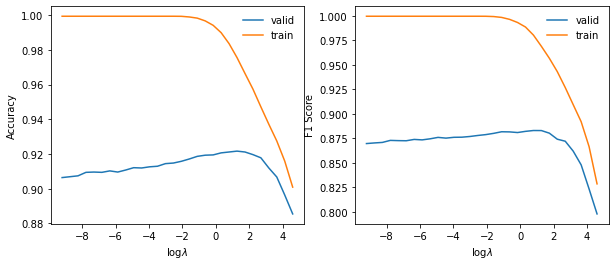

In [16]:
plt.subplots(1,2,figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(np.log(lam_range), val_acc, label='valid')
plt.plot(np.log(lam_range), train_acc, label='train')
plt.xlabel(r'$\log \lambda$')
plt.ylabel('Accuracy')
plt.legend(frameon=False)

plt.subplot(1,2,2)
plt.plot(np.log(lam_range), val_f1, label='valid')
plt.plot(np.log(lam_range), train_f1, label='train')
plt.xlabel(r'$\log \lambda$')
plt.ylabel('F1 Score')
plt.legend(frameon=False);

#### KNN

In [5]:
X_train, y_train = np.load("data/Z_train_rand.npy"), np.load("data/y_train.npy")
X_val, y_val = np.load("data/Z_val_rand.npy"), np.load("data/y_val.npy")

k_range = np.arange(15)+1

knn_out = {}
for k in k_range:
    tic = time.time()
    model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_val)
    
    res = {}
    res['model'] = model
    res['valid'] = { "macro_f1": f1_score(y_val, y_pred, average="macro"),
    "accuracy": accuracy_score(y_val, y_pred)}
    res['train'] = { "macro_f1": f1_score(y_train, y_pred_train, average="macro"),
    "accuracy": accuracy_score(y_train, y_pred_train)}
    toc = time.time()
    print('k = {}, Time: {}'.format(k, format_time(toc-tic)))
    print('Train: {:.4f} || Valid: {:.4f}'.format(res['train']['accuracy'],
                                                 res['valid']['accuracy']))
    print('-'*50)
    knn_out[k] = res

k = 1, Time: 0:02:20
Train: 0.9993 || Valid: 0.8603
--------------------------------------------------
k = 2, Time: 0:11:10
Train: 0.9223 || Valid: 0.8465
--------------------------------------------------
k = 3, Time: 0:11:10
Train: 0.9279 || Valid: 0.8675
--------------------------------------------------
k = 4, Time: 0:11:10
Train: 0.9170 || Valid: 0.8686
--------------------------------------------------
k = 5, Time: 0:11:11
Train: 0.9135 || Valid: 0.8751
--------------------------------------------------
k = 6, Time: 0:11:11
Train: 0.9063 || Valid: 0.8747
--------------------------------------------------
k = 7, Time: 0:11:11
Train: 0.9053 || Valid: 0.8763
--------------------------------------------------
k = 8, Time: 0:11:11
Train: 0.9008 || Valid: 0.8754
--------------------------------------------------
k = 9, Time: 0:11:17
Train: 0.8978 || Valid: 0.8779
--------------------------------------------------
k = 10, Time: 0:11:11
Train: 0.8947 || Valid: 0.8737
--------------------

In [6]:
# save results
knn_outfile = './out/knn_valid_rand.pkl'
with open(knn_outfile, 'wb') as f:
    pickle.dump(knn_out, f)